# Turnover des collaborateurs à l'AN

## Introduction

## Préparation des données

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, linregress

# Fichier généré quotidiennenement par nosdeputes.fr depuis le site de l'AN
csv = pd.read_csv("../data/turnover.csv", encoding='utf-8')

# Parsing des dates de contrat, de mandat et de naissance
csv["entree"] = pd.to_datetime(csv["entree"])
csv["sortie"] = pd.to_datetime(csv["sortie"])
csv["mandat_debut"] = pd.to_datetime(csv["mandat_debut"])
csv["mandat_fin"] = pd.to_datetime(csv["mandat_fin"])
csv["date_naissance"] = pd.to_datetime(csv["date_naissance"])

# Calcul des temps de contrat, de mandat et de l'âge
csv["contrat_fini"] = (csv["sortie"] != max(csv["sortie"]))
csv["duree_mandat"] = csv["mandat_fin"] - csv["mandat_debut"]
csv["duree_mandat"] = csv["duree_mandat"].apply(lambda a: int(a.total_seconds()/60/60/24))
csv["parlementaire_age"] = (max(csv["sortie"]) - csv['date_naissance']).apply(lambda a: int(a.total_seconds()/60/60/24/365))

# Calcul du nombre de contrats courts par parlementaire
csv["contrat_plus_de_2_mois"] = (( (csv["nombredejours"] < 62) & (csv["contrat_fini"] == True)  ) == False) * 1 
csv["contrat_plus_de_4_mois"] = (( (csv["nombredejours"] < 124) & (csv["contrat_fini"] == True) ) == False) * 1
csv["contrat_plus_de_6_mois"] = (( (csv["nombredejours"] < 186) & (csv["contrat_fini"] == True) ) == False) * 1

# Suppression des contrat inférieur à 7 jours (problème liés aux ministres)
csv = csv[csv["nombredejours"] > 7]

# Suppression des contrats courts de début de législature (fin de contrat de la législature précédente)
csv = csv[(csv["entree"] < "2017-09-01") & (csv["nombredejours"] < 30) == False]

# Suppression des colonnes inutiles du fichiers d'entrée
csv.drop("collaborateurs", 1, inplace=True)

### Contrôles

In [2]:
csv

,parlementaire,nom_parlementaire,prénom_parlementaire,sexe_parlementaire,collaborateur,nom_collaborateur,prénom_collaborateur,sexe_collaborateur,url_nosdeputes_api,url_institution,...,nb_mandats,entree,sortie,nombredejours,contrat_fini,duree_mandat,parlementaire_age,contrat_plus_de_2_mois,contrat_plus_de_4_mois,contrat_plus_de_6_mois
0,Louis Aliot,Aliot,Louis,H,Mme Rania Messiha,Messiha,Rania,F,https://www.nosdeputes.fr/louis-aliot/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,2,2017-09-14 01:15:45,2018-06-28 22:00:00,287.0,False,373,48,1,1,1
1,Bertrand Bouyx,Bouyx,Bertrand,H,M. Hugo Guillochin,Guillochin,Hugo,H,https://www.nosdeputes.fr/bertrand-bouyx/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,2017-09-05 01:15:23,2018-06-28 22:00:00,296.0,False,373,48,1,1,1
2,Stéphane Buchou,Buchou,Stéphane,H,Mme Claire Legrand,Legrand,Claire,F,https://www.nosdeputes.fr/stephane-buchou/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,2017-08-03 01:15:27,2018-06-28 22:00:00,329.0,False,373,44,1,1,1
3,Cédric Roussel,Roussel,Cédric,H,Mme Caroline Puisségur-Ripet,Puisségur-Ripet,Caroline,F,https://www.nosdeputes.fr/cedric-roussel/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,2018-03-14 02:15:25,2018-06-28 22:00:00,106.0,False,373,45,1,1,1
4,Isabelle Valentin,Valentin,Isabelle,F,Mme Céline Saby,Saby,Céline,F,https://www.nosdeputes.fr/isabelle-valentin/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,2017-08-20 01:15:28,2018-06-28 22:00:00,312.0,False,373,56,1,1,1
6,Danielle Brulebois,Brulebois,Danielle,F,M. Eddy Lacroix,Lacroix,Eddy,H,https://www.nosdeputes.fr/danielle-brulebois/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,2,2017-08-02 01:15:27,2017-09-05 01:15:23,33.0,True,373,71,0,0,0
7,Laurence Gayte,Gayte,Laurence,F,Mme Frédérique Doutres,Doutres,Frédérique,F,https://www.nosdeputes.fr/laurence-gayte/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,2017-12-09 02:15:23,2017-12-24 02:15:23,15.0,True,373,52,0,0,0
8,Gisèle Biémouret,Biémouret,Gisèle,F,Mme Valérie Lacabanne,Valérie,Lacabanne,F,https://www.nosdeputes.fr/gisele-biemouret/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,2017-07-22 13:01:40,2018-06-28 22:00:00,341.0,False,373,66,1,1,1
9,Dominique David,David,Dominique,F,M. Zébulon Bruneteau-Paoletti,Bruneteau-Paoletti,Zébulon,H,https://www.nosdeputes.fr/dominique-david/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,2018-04-06 01:17:20,2018-05-04 01:15:29,27.0,True,373,55,0,0,0
10,Christophe Lejeune,Lejeune,Christophe,H,M. Stevie Coudray,Coudray,Stevie,H,https://www.nosdeputes.fr/christophe-lejeune/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,2017-09-09 01:15:46,2018-06-28 22:00:00,292.0,False,373,49,1,1,1


### Nombre de collaborateurs 

In [3]:
csv.count()['collaborateur']

2704

## Description générale du comportement des députés

### Préparation des données

In [4]:
duree_collaborateurs = csv.groupby(["parlementaire"])[['groupe_sigle']].first().reset_index()
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['sexe_parlementaire']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nom_circo']].first().rename(columns={"nom_circo": "departement"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].median().rename(columns={"nombredejours": "contrat_mediane"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].mean().rename(columns={"nombredejours": "contrat_moyenne"}).reset_index(), on="parlementaire")

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['collaborateur']].count().rename(columns={"collaborateur": "nb_collaborateurs"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['duree_mandat']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_max"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_min"}).reset_index(), on="parlementaire")

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_2_mois']].sum().rename(columns={"contrat_plus_de_2_mois": "nb_contrats_plus_de_2_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_2_mois'] = duree_collaborateurs['nb_contrats_plus_de_2_mois'] / duree_collaborateurs['nb_collaborateurs']
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_4_mois']].sum().rename(columns={"contrat_plus_de_4_mois": "nb_contrats_plus_de_4_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_4_mois'] = duree_collaborateurs['nb_contrats_plus_de_4_mois'] / duree_collaborateurs['nb_collaborateurs']
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_6_mois']].sum().rename(columns={"contrat_plus_de_6_mois": "nb_contrats_plus_de_6_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_6_mois'] = duree_collaborateurs['nb_contrats_plus_de_6_mois'] / duree_collaborateurs['nb_collaborateurs']

duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].count().rename(columns={"nombredejours": "nb_contrat_fini"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs['nb_contrat_fini'].fillna(0, inplace=True)
duree_collaborateurs['ratio_contrat_fini'] = duree_collaborateurs['nb_contrat_fini'] / duree_collaborateurs['nb_collaborateurs']

duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_fini_max"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_fini_min"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['ancien_depute']].first().reset_index(), on="parlementaire")
duree_collaborateurs["ratio_contrat_mandat"] = duree_collaborateurs["contrat_mediane"] / duree_collaborateurs["duree_mandat"]
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nb_mandats']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['parlementaire_age']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.sort_values("ratio_plus_de_2_mois")#sort_values("contrat le plus long")
duree_collaborateurs.to_csv("../data/duree_collaborateur.csv")

### Durée des contrats de collaborateurs

Certains députés ont des collaborateurs fidèles. Le graphique suivant représente le contrat le plus long de chacun des parlementaires. Les fidèles sont représentés par le palier supérieur à droite du graphique suivant : la durée de leur contrat est égale à la durée de la législature.

Le second palier à 300 jours représente probablement les fidèles des parlementaires suppléants de ministre du gouvernement Philippe 1.

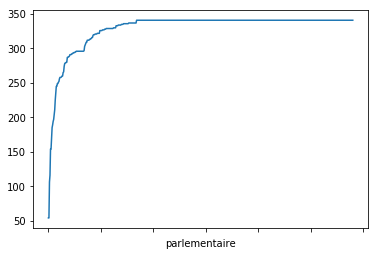

In [5]:
duree_collaborateurs.sort_values("contrat_max").set_index("parlementaire")["contrat_max"].plot()

Le graphique infra représente le contrat le plus court pour chacun des parlementaire.

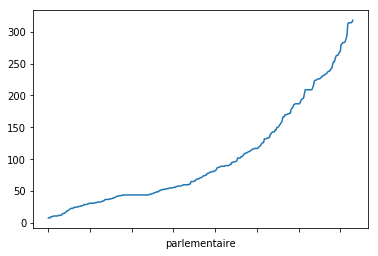

In [6]:
duree_collaborateurs.sort_values("contrat_fini_min").set_index("parlementaire")["contrat_fini_min"].plot()

Certains parlementaires n'ont aucun contrat court, ils n'ont que des collaborateurs fidèles en contrat de longue durée. D'autres se sont parfois séparé d'un collaborateur après moins de 20 jours.

## Les députés et le turnover de leurs collaborateurs

Le tri infra des parlementaires par la durée du contrat de collaborateur le plus long fait remonter ceux qui gardent peu de collaborateurs sur le long terme : leurs collaborateurs n'ont pas beaucoup d'ancienneté, **ils n'ont pas de fidèles**

In [7]:
# Suppression des députés nouvellement élus avant le tri
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('contrat_max').drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "ratio_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1).head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,contrat_mediane,contrat_moyenne,nb_collaborateurs,contrat_max,nb_contrat_fini,ratio_contrat_fini
300,José Evrard,NI,H,Pas-de-Calais,100.0,101.428571,7,154.0,7.0,1.000000
22,Anissa Khedher,LREM,F,Rhône,89.0,107.333333,6,185.0,4.0,0.666667
328,Loïc Dombreval,LREM,H,Alpes-Maritimes,163.0,161.750000,4,189.0,2.0,0.500000
346,Marie Lebec,LREM,F,Yvelines,187.5,185.750000,4,197.0,1.0,0.250000
539,Valérie Petit,LREM,F,Nord,132.0,129.714286,7,204.0,4.0,0.571429
481,Sandra Marsaud,LREM,F,Charente,99.0,113.500000,6,211.0,3.0,0.500000
171,Florence Lasserre-David,MODEM,F,Pyrénées-Atlantiques,57.0,112.400000,5,225.0,3.0,0.600000
377,Michel Vialay,LR,H,Yvelines,139.5,155.000000,4,236.0,2.0,0.500000
526,Thierry Solère,LREM,H,Hauts-de-Seine,141.5,152.333333,6,245.0,4.0,0.666667
308,Jérôme Nury,LR,H,Orne,113.0,120.714286,7,249.0,3.0,0.428571


Le tri croissant par le pourcentage de contrats de plus de 6 mois fait remonter les députés ayant des fidèles mais cumulant de nombreux contrats de mois de 6 mois.

In [8]:
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('ratio_plus_de_6_mois').drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1).head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,contrat_mediane,contrat_moyenne,nb_collaborateurs,contrat_max,ratio_plus_de_6_mois,nb_contrat_fini,ratio_contrat_fini
300,José Evrard,NI,H,Pas-de-Calais,100.0,101.428571,7,154.0,0.000000,7.0,1.000000
14,Alexandre Freschi,LREM,H,Lot-et-Garonne,119.0,144.333333,6,341.0,0.333333,4.0,0.666667
526,Thierry Solère,LREM,H,Hauts-de-Seine,141.5,152.333333,6,245.0,0.333333,4.0,0.666667
131,Danielle Brulebois,LREM,F,Jura,90.0,97.555556,9,294.0,0.333333,6.0,0.666667
22,Anissa Khedher,LREM,F,Rhône,89.0,107.333333,6,185.0,0.333333,4.0,0.666667
191,Frédérique Lardet,LREM,F,Haute-Savoie,122.5,148.333333,6,341.0,0.333333,4.0,0.666667
122,Cédric Roussel,LREM,H,Alpes-Maritimes,109.5,137.250000,8,312.0,0.375000,5.0,0.625000
314,Laurence Maillart-Méhaignerie,LREM,F,Ille-et-Vilaine,79.5,113.875000,8,341.0,0.375000,5.0,0.625000
311,Laure de La Raudière,UAI,F,Eure-et-Loir,151.0,173.571429,7,341.0,0.428571,4.0,0.571429
539,Valérie Petit,LREM,F,Nord,132.0,129.714286,7,204.0,0.428571,4.0,0.571429


Trier les parlementaires par la proportion de contrats clos parmis tous leurs contrats de collaborateur (contrats très courts et parlementaires nouvellement élus exclus) permet d'isoler ceux s'étant souvent séparé de leur personnel.

In [9]:
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('ratio_contrat_fini', ascending=False).drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1).head(15)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,contrat_mediane,contrat_moyenne,nb_collaborateurs,contrat_max,ratio_plus_de_6_mois,nb_contrat_fini,ratio_contrat_fini
300,José Evrard,NI,H,Pas-de-Calais,100.0,101.428571,7,154.0,0.000000,7.0,1.000000
14,Alexandre Freschi,LREM,H,Lot-et-Garonne,119.0,144.333333,6,341.0,0.333333,4.0,0.666667
191,Frédérique Lardet,LREM,F,Haute-Savoie,122.5,148.333333,6,341.0,0.333333,4.0,0.666667
526,Thierry Solère,LREM,H,Hauts-de-Seine,141.5,152.333333,6,245.0,0.333333,4.0,0.666667
173,Florian Bachelier,LREM,H,Ille-et-Vilaine,142.0,157.111111,9,296.0,0.444444,6.0,0.666667
489,Sira Sylla,LREM,F,Seine-Maritime,151.0,141.333333,9,320.0,0.555556,6.0,0.666667
22,Anissa Khedher,LREM,F,Rhône,89.0,107.333333,6,185.0,0.333333,4.0,0.666667
113,Claude de Ganay,LR,H,Loiret,189.5,214.833333,6,341.0,0.666667,4.0,0.666667
131,Danielle Brulebois,LREM,F,Jura,90.0,97.555556,9,294.0,0.333333,6.0,0.666667
314,Laurence Maillart-Méhaignerie,LREM,F,Ille-et-Vilaine,79.5,113.875000,8,341.0,0.375000,5.0,0.625000


Près de la moitié des parlementaires ont déjà mis fin à un contrat dans une durée de moins de 4 mois : la période d'essai d'un CDI de collaborateur est de 2 mois.

In [10]:
duree_collaborateurs[duree_collaborateurs["contrat_fini_min"] < 120]["parlementaire"].count() * 100 / duree_collaborateurs["parlementaire"].count()

43.545611015490536

## L'influence des groupes politiques

Les durées moyennes de contrat par groupe politique pointe les non-inscrits comme le groupe parlementaires qui garde le moins longtemps ses collaborateurs.

In [11]:
duree_collaborateurs[["groupe_sigle", "contrat_mediane"]].groupby("groupe_sigle").mean().sort_values("contrat_mediane")

,contrat_mediane
groupe_sigle,
NI,213.525000
LREM,249.968153
MODEM,253.787234
LR,266.274510
GDR,269.029412
UAI,276.106061
LFI,285.235294
NG,286.032258


# L'influence du sexe

Les durées médianes des contrats de collaborateurs femmes et hommes indiquent que les femmes restent en poste sensiblement plus longtemps, alors que collaborer avec une parlementaire femme mène à des contrats plus courts.

In [12]:
collab_femme_vs_homme = csv.groupby(["sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].median()
collab_femme_vs_homme

,nombredejours
sexe_collaborateur,
F,277.0
H,263.0


In [13]:
depute_femme_vs_homme = csv.groupby(["sexe_parlementaire"])[['nombredejours', 'sexe_collaborateur']].median()
depute_femme_vs_homme

,nombredejours
sexe_parlementaire,
F,245.0
H,281.0


On observe que seules les parlementaires femmes montrent une préférences de genre envers les hommes pour leurs collaborateurs, mais cela n'influe pas sur la durée des contrats des collaborateurs.

In [15]:
duree_moy_sexe = csv.groupby(["parlementaire", "sexe_parlementaire", "sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].mean()
nb_collab_sexe = csv.groupby(["parlementaire", "sexe_collaborateur"])[['collaborateur']].count().rename(columns={'collaborateur': 'nb_collaborateurs'})
stats_sexe = duree_moy_sexe.reset_index().merge(nb_collab_sexe.reset_index(), on=["parlementaire", "sexe_collaborateur"])
stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nombredejours"]].mean()

nombredejours
sexe_parlementaire sexe_collaborateur               
F                  F                      238.298953
                   H                      224.310753
H                  F                      252.343284
                   H                      248.028012

In [16]:
nb = stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nb_collaborateurs"]].sum()
moy = stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nb_collaborateurs"]].mean()["nb_collaborateurs"].rename(columns={"nb_collaborateurs": "nb_collaborateurs_moyen"})

moy.reset_index().merge(nb.reset_index(), on=["sexe_parlementaire", "sexe_collaborateur"]).set_index(["sexe_parlementaire", "sexe_collaborateur"])


0  nb_collaborateurs
sexe_parlementaire sexe_collaborateur                             
F                  F                   2.425926                524
                   H                   2.603687                565
H                  F                   2.438806                817
                   H                   2.403614                798

## Tests statistiques sur les parlementaires

### Préparation des données

In [ ]:
# Dichotomisation des variables
duree_tt = duree_collaborateurs
duree_tt["parlementaire_femme"] = (duree_tt["sexe_parlementaire"] == "F") * 1
duree_tt["parlementaire_homme"] = (duree_tt["sexe_parlementaire"] == "H") * 1
duree_tt["parlementaire_has_autre_mandats"] = (duree_tt["nb_mandats"] > 1) * 1
duree_tt["ancien_depute"] = (duree_tt["ancien_depute"]) * 1
for grp in duree_tt["groupe_sigle"].unique():
    duree_tt["groupe_"+grp] = (duree_tt["groupe_sigle"] == grp) * 1

# Inputation des valeurs manquantes
duree_tt["contrat_fini_min"].fillna(150, inplace=True)
duree_tt["contrat_fini_max"].fillna(150, inplace=True)

### Test de significativité des variables dichotomiques

Pour chacune des variables booléennes décrivant les parlementaires (sexe, groupes, etc.) on effectue un test indiquant son effet sur la durée moyenne des contrats de ses collaborateurs.

In [ ]:
for i in duree_tt.drop(["nb_contrat_fini", "ratio_contrat_fini","contrat_mediane", "contrat_moyenne", "nb_collaborateurs", "parlementaire_age", "duree_mandat", "nb_mandats","contrat_max", "contrat_min", "ratio_contrat_mandat", "contrat_fini_max", "contrat_fini_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois","nb_contrats_plus_de_4_mois","ratio_plus_de_4_mois","nb_contrats_plus_de_6_mois","ratio_plus_de_6_mois"], 1).columns[4:]:
    cat2 = duree_tt[duree_tt[i] == 0]["contrat_moyenne"]
    cat1 = duree_tt[duree_tt[i] == 1]["contrat_moyenne"]

    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

### Tests de régression sur les variables continues

Pour chacune des variables continues, telles que l'âge ou le nombre de collaborateurs, décrivant les parlementaires, on effectue un test de régression qui nous indique son effet sur la durée moyenne de ses contrats.

In [ ]:
tt = {}
for i in duree_tt.columns[4:].drop(["contrat_moyenne", "contrat_mediane", "duree_mandat", "ratio_plus_de_2_mois", "ratio_plus_de_4_mois", "ratio_plus_de_6_mois", "ratio_contrat_fini"], 1):
    tt[i] = linregress(duree_tt["contrat_moyenne"], duree_tt[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(duree_tt["contrat_moyenne"], duree_tt[i], 'o', label=i)
        plt.plot(duree_tt["contrat_moyenne"], tt[i].intercept + tt[i].slope*duree_tt["contrat_moyenne"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")

## Tests statistiques sur les collaborateurs

### Préparation des données

In [ ]:
tous_collaborateurs = csv.merge(duree_collaborateurs.drop([ 'groupe_sigle', 'sexe_parlementaire', 'duree_mandat', 'nb_mandats', 'parlementaire_age', 'ancien_depute'], 1), on="parlementaire")
tous_collaborateurs["collaborateur_femme"] = (tous_collaborateurs["sexe_collaborateur"] == "F") * 1
tous_collaborateurs["collaborateur_homme"] = (tous_collaborateurs["sexe_collaborateur"] == "H") * 1
tous_collaborateurs.to_csv("../data/turnover_collaborateurs_variables.csv")
tous_collaborateurs = tous_collaborateurs.drop(["entree", "sortie"], 1)

tous_collaborateurs = tous_collaborateurs.drop(['groupe_sigle', 'parti_ratt_financier', 'sites_web','emails', 'adresses', 'autres_mandats', 'anciens_autres_mandats', 'anciens_mandats', 'profession', 'place_en_hemicycle', 'url_an', 'id_an', 'slug', 'url_nosdeputes', "duree_mandat", "departement"], 1)
tous_collaborateurs.columns[24:]

### Test de significativité des variables dichotomiques

In [ ]:
for i in tous_collaborateurs.columns[24:].drop(["contrat_fini", "contrat_plus_de_2_mois", "nombredejours","contrat_plus_de_4_mois", "contrat_plus_de_6_mois","parlementaire_age","contrat_mediane","contrat_moyenne","nb_collaborateurs","contrat_max","contrat_min","nb_contrats_plus_de_2_mois","ratio_plus_de_2_mois","nb_contrats_plus_de_4_mois","ratio_plus_de_4_mois","nb_contrats_plus_de_6_mois","ratio_plus_de_6_mois","nb_contrat_fini","ratio_contrat_fini","contrat_fini_max","contrat_fini_min","ratio_contrat_mandat"], 1):
    cat2 = tous_collaborateurs[tous_collaborateurs[i] == 0]["nombredejours"]
    cat1 = tous_collaborateurs[tous_collaborateurs[i] == 1]["nombredejours"]
    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

### Tests de régression sur les variables continues

In [ ]:
tt = {}
for i in tous_collaborateurs.drop(["nombredejours", "contrat_moyenne", "contrat_mediane", "ratio_plus_de_2_mois","ratio_plus_de_4_mois","ratio_plus_de_6_mois"], 1).columns[24:]:
    tt[i] = linregress(tous_collaborateurs["nombredejours"], tous_collaborateurs[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(tous_collaborateurs["nombredejours"], tous_collaborateurs[i], 'o', label=i)
        plt.plot(tous_collaborateurs["nombredejours"], tt[i].intercept + tt[i].slope*tous_collaborateurs["nombredejours"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")

## Conclusions